#### Here are my results for Lab 4 but I do not know if I did the work correctly. If you have any feedback, please let me know. Also if you have physical intuition about this problem, I would appreciate hearing about it.
#### mlowe@loyola.edu

# Lab 4 Simulating Nature at Utility Scale

In this lab we will explore utility scale work by simulating the dynamics of a large Heisenberg spin chain. The goal is to measure the dynamics of $Z_i$ for a given site as a function of time and external field $h$ for two different phases of the spin chain.

This lab will be broken into sections matching the Qiskit Patterns framework which include the following steps:

1. Map the system to quantum circuits and operators
2. Optimize the circuits to be executed
3. Execute the time evolution circuits
4. Analyze or post-process the results

### Introduction
The Heisenberg model, introduced in the late 1920s, is a popular model used to study magnetic phenomena and phase transitions in many-body systems. It is related to its more simplified cousin, the Ising model, and examines the dynamics that emerge from what is known as the *exchange interaction*. This interaction arises from a combination of the Pauli exclusion principle and the Coulomb interaction [[1]](https://doi.org/10.1119/1.4798343) and has a Hamiltonian of the form:

$$ H = \sum_{i=1}^N\left(J_x X_iX_{i+1} + J_y Y_iY_{i+1} + J_z Z_iZ_{i+1}\right). $$

Here $N$ is the number of sites in our chain and $X_i$, $Y_i$, and $Z_i$ are the Pauli operators which act on the $i^{th}$ site. The parameters $J_x$, $J_y$, and $J_z$, represent the coupling strength for the Coulomb ($J_x$ and $J_y$) and Ising ($J_z$) interaction. For the rest of the lab we'll consider $J_x=J_y=1$ for simplicity. 

In general this model has a few phases based on the ratio $\Delta = J_z/J$ (also known as the anisotropy). In this lab we will explore two of them:
- The **istropic** phase where $\Delta = 1$. This is also known as the **XXX** phase.
- The **anisotropic** phase when $\Delta \neq 1$.

To measure some interesting dynamics of this system, we will also introduce a transverse magnetic field with a strength $h$ which will interact with each site through the Pauli $X$ operator. The Hamiltonian of our spin chain will now take the form:

\begin{align} 
H =& \sum_{i=1}^N\left(J X_iX_{i+1} + J Y_iY_{i+1} + J_z Z_iZ_{i+1} + hX_i\right) \\
    =& \sum_{i=1}^N\left(X_iX_{i+1} + Y_iY_{i+1} + \Delta Z_iZ_{i+1} + hX_i\right)
\end{align}

where we have substituted $\Delta = J_z/J$.

## Step 0: Setup

The code cells below will install all the required packages needed for this lab, you will also set your API token as an environment variable which the grader will need to save your progress.

In [1]:
%pip install qiskit[visualization]==1.1.0
# Use the following if you are on MacOS/zsh
#!pip install 'qiskit[visualization]'==1.1.0
%pip install qiskit_ibm_runtime
%pip install matplotlib
%pip install pylatexenc
%pip install networkx
%pip install git+https://github.com/ryanhill1/Quantum-Challenge-Grader.git


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/.qbraid/environments/qbraid_000000/pyenv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/.qbraid/environments/qbraid_000000/pyenv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/.qbraid/environments/qbraid_000000/pyenv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/.qbraid/environments/qbraid_000000/pyenv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 

## Step 1: Map the system to quantum circuits and operators


In this lab we will examine the dynamics of the expectation value $\langle Z_i \rangle$ averaged over each site as a function of the field strength $h$. In the experiments below, you will prepare a circuit which implements the time evolution operator acting on the state $|000...0\rangle$ according to the system parametersFor simplicity we will should set $\delta t = \frac{\pi}{4}$. This ensures that $\theta_J = -2J_z\delta t = -\frac{\pi}{2}$ which makes the time evolution of our system much simpler for the isotropic phase.

In this first exercise, you will create a function to generate the Hamiltonian in the form of a `SparsePauliOp` object. We'll introduce the modules you'll need, define some system parameters, and demonstrate a quick example of how you might want to accomplish this task.

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.synthesis import LieTrotter

from qiskit_ibm_runtime.options import EstimatorOptions, DynamicalDecouplingOptions
from qiskit_ibm_runtime import EstimatorV2, Batch

import numpy as np
import matplotlib.pyplot as plt
import json


## Step 4: Post-Process

In these last two exercises you will retrieve and post-process your results.

### Exercise 7: Retrieve your job results
For this exercise you'll use the `service.job(job_id)` method in order to retrieve your jobs by job id. You can obtain these ids either from the dictionary you defined earlier or by loading the json file which you saved them to. The lab assumes that the data you retrieve will be in the form of a dictionary whose keys associate with each phase you simulated and corresponding values contain a list of the job data.




In [3]:
# Code to grab all of the expectation values. Anisotropic case: 
# Exercise 7: Parse all the data

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='events/qgss/24-8',
    token='***'
)

job = service.job('ctngwjt4gzyg008zg940')

job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")
    
#pub_result = job.result()[11]
#values = pub_result.data.evs
#print(f"Expectation values for pub [11]: {values}")
    
# https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService#jobs
# https://docs.quantum.ibm.com/guides/monitor-job

Expectation values for pub 0: [0.81571047 0.85484857 0.76506313 0.78948047 1.15717987 1.10325299
 1.3200847  0.89757171 1.34010816 0.85366594 0.81968722 0.46760491
 0.94905709 0.24027198 0.10695171 0.10354202 0.13213325 0.7412065
 0.67058069 0.92001268 0.61869254 0.8708431  1.05222078 1.15962165
 0.44567831 0.42586209 0.385429   1.19961848 0.87589938 1.04294029
 0.83431114 0.98053263 1.01004418 1.0449065  0.92952241 1.14504941
 1.17215613 0.85564328 0.97201384 0.76945966 1.0308478  0.70741309
 1.5968245  1.1140778  0.80344233 0.96058286 0.9012848  0.8598877
 0.86579918 0.88056728]
Expectation values for pub 1: [0.79494446 0.57899231 0.77004937 0.85888539 0.86204386 0.71552062
 0.75980297 1.08569504 0.95561552 0.92087444 0.79763157 0.7119615
 0.85044154 0.68405791 0.74241817 0.36590914 0.98752809 0.37587268
 0.46246542 0.85791011 0.73162003 0.71681037 0.70761658 0.80480182
 0.85833579 0.66407585 0.95202168 0.79888226 0.61559196 0.67422766
 0.74657136 0.77531169 0.98162101 0.6874475  0.9

### Exercise: 8 Compute and plot your results

In this final exercise, you will use the `PrimitiveResult` data and obtain the average $\langle Z_i \rangle$ over each site as a function of the field strength $h$. Once the averages have been obtained, store them in a dictionary called `avg_z_data` whose keys correspond to each phase. Finally, plot this data using a tool such as matplotlib to view the results side by side.

The two phases are the *Anisotropic* phase ($\Delta = -5$) and the *XXX* phase ($\Delta = 1$).

# Run Anisotropic

Anisotropic i= 0
Anisotropic i= 1


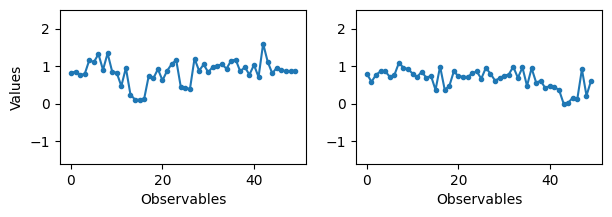

Anisotropic i= 2
Anisotropic i= 3


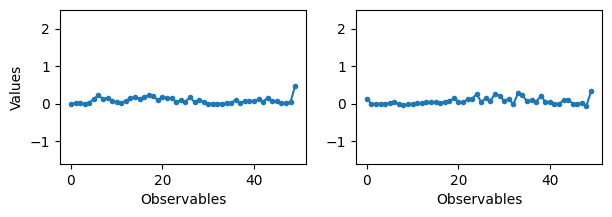

Anisotropic i= 4
Anisotropic i= 5


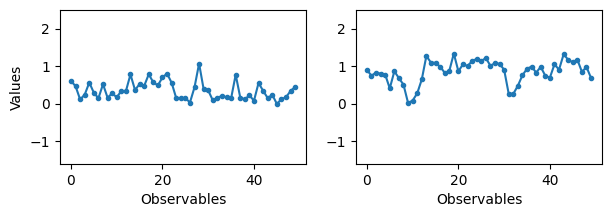

Anisotropic i= 6
Anisotropic i= 7


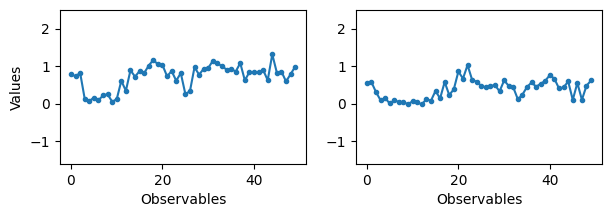

Anisotropic i= 8
Anisotropic i= 9


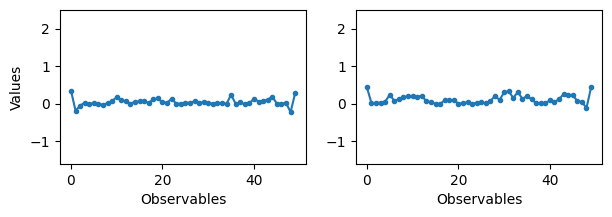

Anisotropic i= 10
Anisotropic i= 11


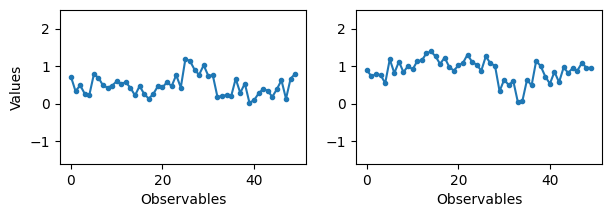

In [4]:
# Your code goes here
from matplotlib import pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='events/qgss/24-8',
    token='***'
)
job = service.job('ctngwjt4gzyg008zg940')

job_result = job.result()
xgrid = np.linspace(0, 49, 50)

num_subplots = 2

for i in range(12):
    print("Anisotropic i=",i)
    pub_result = job.result()[i]
    values = pub_result.data.evs
    #Produces list with 50 values for 50 spins.

    errors = pub_result.data.stds

    # plotting graph
    
    if i%2 == 0:
        plt.figure(figsize=(7,2))
        plt.subplot(1, num_subplots,1)
        plt.plot(xgrid, values, marker='.')
        plt.ylim(-1.6, 2.5)
        plt.xlabel('Observables')
        plt.ylabel('Values')
        
    if i%2 == 1:
        plt.subplot(1, num_subplots,2)
        plt.plot(xgrid, values, marker='.')
        plt.ylim(-1.6, 2.5)
        plt.xlabel('Observables')
        plt.show()


## Run XXX


/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qiskit/qpy/interface.py:305: UserWarning: The qiskit version used to generate the provided QPY file, 1.1.1, is newer than the current qiskit version 1.1.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


XXX i= 0
XXX i= 1


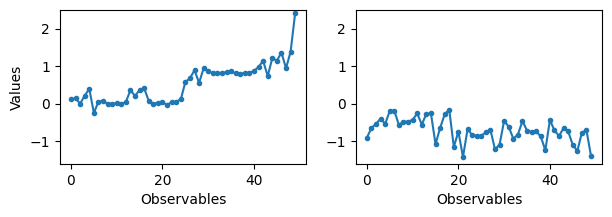

XXX i= 2
XXX i= 3


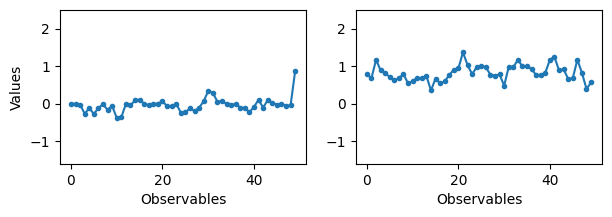

XXX i= 4
XXX i= 5


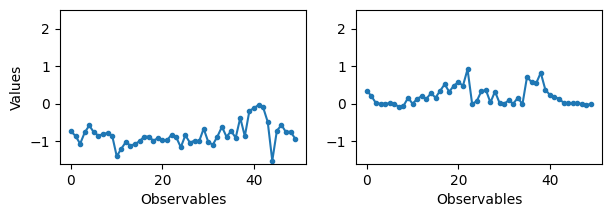

XXX i= 6
XXX i= 7


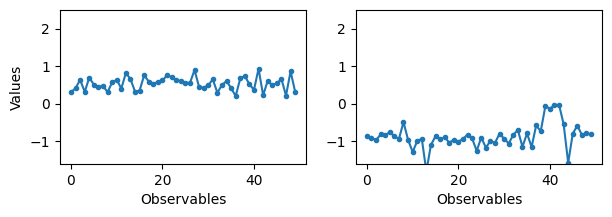

XXX i= 8
XXX i= 9


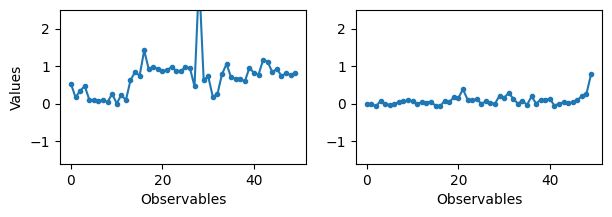

XXX i= 10
XXX i= 11


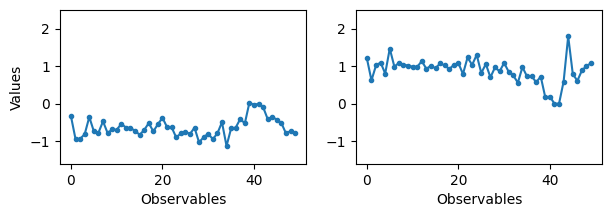

In [5]:
# Code to grab all of the expectation values
# Exercise 7: Parse all the data
# XXX run
all_job_data = {}

from qiskit_ibm_runtime import QiskitRuntimeService
from matplotlib import pyplot as plt
import numpy as np

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='events/qgss/24-8',
    token='***'
)
job = service.job('ctq9bwzx7b5g0080rwdg')

job_result = job.result()

#for idx, pub_result in enumerate(job_result):
    #print(f"Expectation values for pub {idx}: {pub_result.data.evs}")
    
#pub_result = job.result()[11]
#values = pub_result.data.evs
#print(f"Expectation values for pub [11]: {values}")

# Plot results
avg_z_data = {}

xgrid = np.linspace(0, 49, 50)

num_subplots = 2

for i in range(12):
    print("XXX i=",i)
    pub_result = job.result()[i]
    values = pub_result.data.evs
    #Produces list with 50 values for 50 spins.

    errors = pub_result.data.stds

    # plotting graph

    if i%2 == 0:
        plt.figure(figsize=(7,2))
        plt.subplot(1, num_subplots,1)
        plt.plot(xgrid, values, marker='.')
        plt.ylim(-1.6, 2.5)
        plt.xlabel('Observables')
        plt.ylabel('Values')
 
    if i%2 == 1:
        plt.subplot(1, num_subplots,2)
        plt.plot(xgrid, values, marker='.')
        plt.ylim(-1.6, 2.5)
        plt.xlabel('Observables')
        plt.show()
    
# https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService#jobs
# https://docs.quantum.ibm.com/guides/monitor-job

# Another interpretation of the question.

XXX calculation is done. Wait for Anisotropic calculation


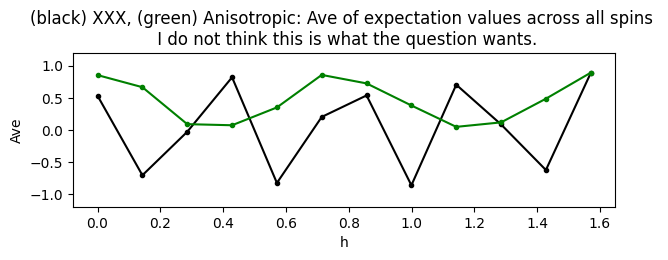

In [6]:
# The question is phrased: In this final exercise, you will use the `PrimitiveResult` data
# and obtain the average $\langle Z_i \rangle$ over each site as a function of the field strength $h$.
# This question suggests that the expectation value (which is an average) should be computed for each spin.
# This will result in 12 graphs for XXX and 12 graphs for Anisotropic (see above.)
# If, however, you interpret average $\langle Z_i \rangle$ as the average of the expectation values
# over all spins, you will get the following:

# First run first two cells
# The two phases are the *Anisotropic* phase ($\Delta = -5$) and the *XXX* phase ($\Delta = 1$).

# XXX results
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='events/qgss/24-8',
    token='***'
)
job = service.job('ctq9bwzx7b5g0080rwdg')
job_result = job.result()

h_vals = np.linspace(0., np.pi/2, 12)
averagesXXX = []

for i in range(12):
    h_val = h_vals[i]
    pub_result = job.result()[i]
    values = pub_result.data.evs
    #print("i=",i, "len:", len(values), "h_val:", h_val)
    average = np.average( values )
    averagesXXX.append( average )
    
plt.figure(figsize=(7,2))
plt.plot(h_vals, averagesXXX, marker='.', color='k')
plt.ylim(-1.2, 1.2)
plt.xlabel('h')
plt.ylabel('Ave')
plt.title('(black) XXX, (green) Anisotropic: Ave of expectation values across all spins \n I do not think this is what the question wants.')
print('XXX calculation is done. Wait for Anisotropic calculation')

# Anisotropic results
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='events/qgss/24-8',
    token='***'
)
job = service.job('ctngwjt4gzyg008zg940')
job_result = job.result()

averagesAniso = []

for i in range(12):
    h_val = h_vals[i]
    pub_result = job.result()[i]
    values = pub_result.data.evs
    #print("i=",i, "len:", len(values), "h_val:", h_val)
    average = np.average( values )
    averagesAniso.append( average )
    
plt.plot(h_vals, averagesAniso, marker='.', color='g')
plt.show()


In [7]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()